# XGBoost (from scratch)

## Bagging Vs Boosting Ensamble Techinques

- __Bagging__: Build many independent predictors/models/learners often refered as week learners and combine them using some model averaging techniques. (e.g. weighted average, majority vote or normal average). The technique takes many uncorrelated week learners to make a final model, it reduces error by reducing variance. A good example is __Random Forest__
- __Boosting__: In this techinique predictors are not made independently, but sequentially. It employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. A good example is __Gradient Boosting__

![BaggingVsBoosting.png](attachment:BaggingVsBoosting)

### Gradient Boosting: 
It is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. (Wikipedia definition). The objective of any supervised learning algorithm is to define a loss function and minimize it. In this case it can be Mean Absolute Error (MAE) that is minimized at median or mean squared error (MSE) minimized on mean. The loss for MSE is defined as

$J(y_i, y^p_i) = Loss = MSE = \frac{1}{2m}\sum_{i=1}^m(y_i - y^p_i)^2$

where, $y_i$ is the ith target value and $y^p_i$ it the ith rediction. 

By using gradient descent and updating our predictions based on a learning rate, we can find the values where $MSE$ is minimum.


$y^p_i = y^p_i - 2m ~\alpha  \frac{\partial}{\partial y^p_i} J(y_i, y^p_i) $

$y^p_i = y^p_i +  \alpha \sum_{i=1}^m(y_i - y^p_i)  $


Here $\alpha$ is the learning rate and $\sum_p (y_i - y^p_i)$ is sum of the residuals.


#### The following code is a simple XGBoost model developed using numpy.
Tha main purpose of this code is to unveil the maths behind XGBoost

In [2]:
import numpy as np
import pandas as pd
#print(pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

### Data 1
Consider the following data where the years of experience is predictor variable and salary is the target.

,Years,Salary
0,5,82
1,7,80
2,12,103
3,23,118
4,25,172


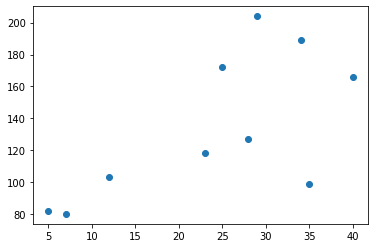

In [78]:
year = [5,7,12,23,25,28,29,34,35,40]
salary = [82,80,103,118,172,127,204,189,99,166]

x = np.arange(0,50)
x = pd.DataFrame({'x':x})

df = pd.DataFrame(columns=['Years','Salary'])
df.Years = year
df.Salary = salary
display(df.head())

plt.scatter(x=df.Years,y=df.Salary)

### Data 2

Lets draw purely uniform distributions for certain x-ranges.

,Years,Salary
0,0,14.654698
1,1,13.727194
2,2,10.025226
3,3,12.445035
4,4,11.029748


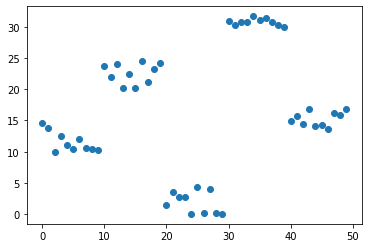

In [15]:
x = np.arange(0,50)

# just random uniform distributions in differnt range
y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)
y = np.concatenate((y1,y2,y3,y4,y5))

#f = lambda x: np.sin(x[:,0]*3*np.pi) + 0.15 * np.random.randn(x.size)
#np.random.seed(2)
#x = np.random.rand(100, 1) - 0.5 # 100 training data points centered around 0.5
#y = f(x) # 3 pi sinx + 0.15 (noise=“standard normal” distribution)

#y = y[:,None]
#df = pd.Series(y)

df = pd.DataFrame(columns=['Years','Salary'])
df.Years = x#x[:,0]
df.Salary = y
display(df.head())

plt.scatter(x=df.Years,y=df.Salary)
#plt.scatter(x, y=df)

### Model
- Using regression trees as base learners, we can create a model to predict the salary. 
- Lets choose MSE as our loss function and our objective would be to minimize the squared error.
- As the first step, the model should be initialized with a function F0(x), a function which minimizes the loss function or MSE.

- __Steps:__
    - Initialize the model with a function f0(x) = mean of target varaible, which is the solution of the function F0(x) which minimizes the MSE (loss)
    - Compute the residual between y0 and f0 i.e. (y0-f0)
    - Build a binary tree by randomly splitting the residual into two arrays of different sizes, compute the mean of each leaf and save it in a regression tree h1(x). 
    - In the second iteration, start building the additive model such as f1(x) = f0(x) + h1(x). The output of h1(x) will help in predicting the successive function F1(x) which will bring down the residuals. 
    - Then the third iteration the additive model will be f2(x) = f0(x) + h1(x) + h2(x), and so on, such that residual is reduced in every step.
    

In [16]:
df1 = df

m = 100

for i in range(m):
    f = df.Salary.mean()
    #print(str(i)+'th iteration ===> \n')
    
    # Model:
    # start from the mean salary (f0), and add the mean of the residual (h1) such as f1= f0 + h1
    # ======
    if(i>0):
        # add mean  of the residual to the mean
        df['f'+str(i)] = df['f'+str(i-1)] + df['h'+str(i)] 
        
    else:
        df['f'+str(i)] = f
        
    #print('f'+str(i)+' = ', df['f'+str(i)].to_numpy())  
    
    # residual
    df['y-f'+str(i)] = df.Salary - df['f'+str(i)]
    
    #print('(y-f'+str(i)+') = ', df['y-f'+str(i)].to_numpy())
    
    # Binary Tree:
    # =============
    
    # create a binary tree, by splitting the residual into random size
    splitIndex = np.random.randint(len(df)-1)
    #print('split index = ', splitIndex)
     
    # save the mean of each leaf in additive model h   
    h_upper = df['y-f'+str(i)][0:splitIndex].mean()
    upper = [round(h_upper,3) for j in range(splitIndex)] 
    
    h_bottom = df['y-f'+str(i)][splitIndex:].mean()             
    bottom = [round(h_bottom,3) for j in range(len(df) - splitIndex)] 
      
    # save the mean of residuals from both leaves   
    df['h'+str(i+1)] =  upper+bottom 
    #print( 'h'+str(i+1)+' = ',  upper+bottom, '\n')
    
df.head()


,Years,Salary,f0,y-f0,h1,f1,y-f1,h2,f2,y-f2,...,h97,f97,y-f97,h98,f98,y-f98,h99,f99,y-f99,h100
0,0,14.654698,16.422758,-1.768060,-4.556,11.866758,2.787940,1.309,13.175758,1.478940,...,-0.728,14.188758,0.465940,0.514,14.702758,-0.048060,0.177,14.879758,-0.225060,-0.354
1,1,13.727194,16.422758,-2.695564,-4.556,11.866758,1.860436,1.309,13.175758,0.551436,...,-0.728,12.638758,1.088436,0.514,13.152758,0.574436,0.177,13.329758,0.397436,-0.354
2,2,10.025226,16.422758,-6.397532,-4.556,11.866758,-1.841532,1.309,13.175758,-3.150532,...,-0.728,9.102758,0.922468,0.514,9.616758,0.408468,0.177,9.793758,0.231468,-0.354
3,3,12.445035,16.422758,-3.977723,-4.556,11.866758,0.578277,1.309,13.175758,-0.730723,...,-0.728,11.439758,1.005277,0.514,11.953758,0.491277,0.177,12.130758,0.314277,-0.354
4,4,11.029748,16.422758,-5.393010,-4.556,11.866758,-0.837010,1.309,13.175758,-2.146010,...,-0.728,11.406758,-0.377010,0.514,11.920758,-0.891010,0.177,12.097758,-1.068010,-0.354


# Plot

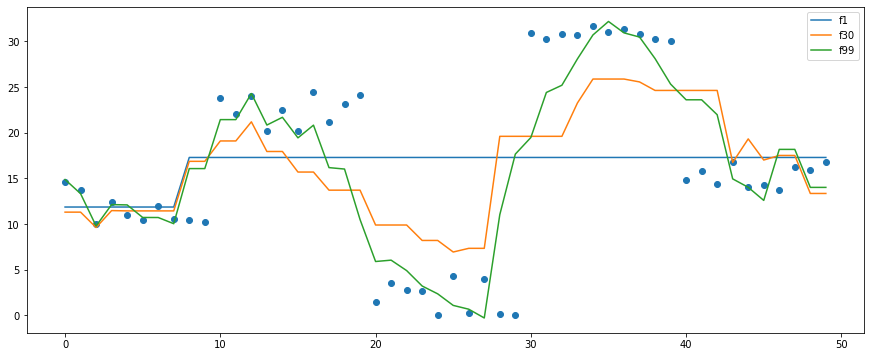

In [17]:
plt.figure(figsize=(15,6))
plt.scatter(df.Years,df.Salary)
plt.plot(df.Years,df.f1.to_numpy(),label = 'f1')
plt.plot(df.Years,df.f30.to_numpy(),label = 'f30')
plt.plot(df.Years,df.f99.to_numpy(),label = 'f99')
plt.legend()

#                                               END

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


